In [ ]:
import numpy as np

from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [22]:
#Get a list of all species names
species_list = ['alligator_mississippiensis', 'anolis_carolinensis', 'anopheles_gambiae', 'apis_mellifera', 'arabidopsis_thaliana', 'aspergillus_nidulans', 'bos_taurus', 'brachypodium_distachyon', 'caenorhabditis_elegans', 'canis_lupus_familiaris', 'columba_livia', 'coprinopsis_cinerea', 'cryptococcus_neoformans', 'danio_rerio', 'daphnia_carinata', 'dictyostelium_discoideum', 'drosophila_melanogaster', 'eimeria_maxima', 'entamoeba_histolytica', 'equus_caballus', 'gallus_gallus', 'giardia_intestinalis', 'glycine_max', 'gorilla_gorilla', 'homo_sapiens', 'hordeum_vulgare', 'leishmania_donovani', 'lotus_japonicus', 'manduca_sexta', 'medicago_truncatula', 'mus_musculus', 'neurospora_crassa', 'nicotiana_tabacum', 'oreochromis_niloticus', 'oryctolagus_cuniculus', 'oryza_sativa', 'oryzias_latipes', 'ovis_aries', 'pan_troglodytes', 'phoenix_dactylifera', 'plasmodium_falciparum', 'rattus_norvegicus', 'rhizophagus_irregularis', 'saccharomyces_cerevisiae', 'schizophyllum_commune', 'schizosaccharomyces_pombe', 'selaginella_moellendorffii', 'setaria_viridis', 'solanum_lycopersicum', 'strongylocentrotus_purpuratus', 'sus_scrofa', 'taeniopygia_guttata', 'toxoplasma_gondii', 'tribolium_castaneum', 'trichoplax_adhaerens', 'triticum_aestivum', 'trypanosoma_brucei', 'ustilago_maydis', 'xenopus_laevis', 'zea_mays']

protozoa_list = ['plasmodium_falciparum', 'entamoeba_histolytica', 'dictyostelium_discoideum',
                 'giardia_intestinalis', 'trypanosoma_brucei', 'leishmania_donovani', 
                 'toxoplasma_gondii', 'eimeria_maxima']

fungi_list = ['saccharomyces_cerevisiae', 'ustilago_maydis', 'schizosaccharomyces_pombe',
              'aspergillus_nidulans', 'cryptococcus_neoformans', 'neurospora_crassa', 
              'coprinopsis_cinerea', 'rhizophagus_irregularis', 'schizophyllum_commune']

plants_list = ['oryza_sativa', 'arabidopsis_thaliana', 'selaginella_moellendorffii', "brachypodium_distachyon", 
               "setaria_viridis", "zea_mays", "hordeum_vulgare", 
               "triticum_aestivum", "phoenix_dactylifera", "lotus_japonicus",
               "medicago_truncatula", "nicotiana_tabacum", "glycine_max", "solanum_lycopersicum"]

invertebrates_list = ['trichoplax_adhaerens', 'tribolium_castaneum', 'manduca_sexta', 
                      'apis_mellifera', 'strongylocentrotus_purpuratus', 'daphnia_carinata', 
                      'drosophila_melanogaster', 'anopheles_gambiae', 'caenorhabditis_elegans']

vertebrates_list = ['gallus_gallus', 'alligator_mississippiensis', 'xenopus_laevis',
                    'oreochromis_niloticus', 'homo_sapiens', 'bos_taurus', "mus_musculus", "ovis_aries", "canis_lupus_familiaris", 
                    "equus_caballus", "gorilla_gorilla", "pan_troglodytes",
                    "rattus_norvegicus", "oryctolagus_cuniculus", "sus_scrofa",
                    "danio_rerio", "oryzias_latipes", "taeniopygia_guttata",
                    "columba_livia", "anolis_carolinensis"]

In [23]:
netstart_overall_df = pd.read_csv('../../data/data_evaluation/preds_processed/testset/netstart_overall_df.csv.gz')
netstart_phylum_df = pd.read_csv('../../data/data_evaluation/preds_processed/testset/netstart_phylum_level_df.csv.gz')
netstart_species_unknown_df = pd.read_csv('../../data/data_evaluation/preds_processed/testset/netstart_species_unknown_df.csv.gz')
TIS_transformer_df_full = pd.read_csv('../../data/data_evaluation/preds_processed/testset/TIS_transformer_df.csv.gz')

In [25]:
netstart_overall_df = netstart_overall_df[~netstart_overall_df["seq_type"].isin(["Intron", "Intergenic"])]
netstart_phylum_df = netstart_phylum_df[~netstart_phylum_df["seq_type"].isin(["Intron", "Intergenic"])]
netstart_species_unknown_df = netstart_species_unknown_df[~netstart_species_unknown_df["seq_type"].isin(["Intron", "Intergenic"])]
TIS_transformer_df = TIS_transformer_df_full[~TIS_transformer_df_full["seq_type"].isin(["Intron", "Intergenic"])]

In [26]:
def extract_similar_sequences(species, threshold):
    """ 
    Extract sequence numbers of sequences homologous to TIS Transformer training data. 
    """
    similar_sequences = []
    with open(f"../../data/data_evaluation/TIS_transformer/similar_sequences/similar_sequences_{species}.txt", "r") as infile:
        for line in infile:
            if float(line.split("|")[1].strip()) > threshold:
                similar_sequences.append(line.split("|")[0])

    return similar_sequences

In [ ]:
TIS_transformer_df_placeholder = pd.DataFrame()
netstart_overall_df_placeholder = pd.DataFrame()
netstart_phylum_df_placeholder = pd.DataFrame()
netstart_species_unknown_df_placeholder = pd.DataFrame()

##Remove sequences homologous to TIS Transformer training set for comparison with the other results (use the same testset)
for species in species_list:
    similar_sequences_species = extract_similar_sequences(species, 50)
    all_sequences_species = TIS_transformer_df[(TIS_transformer_df["species"] == species) & (TIS_transformer_df["label"] == 1.0)]

    #Get non-homologous species data
    TIS_transformer_df_species = TIS_transformer_df[(TIS_transformer_df["species"] == species) & (~TIS_transformer_df["seq_number"].isin(similar_sequences_species))]
    netstart_overall_df_species = netstart_overall_df[(netstart_overall_df["species"] == species) & (~netstart_overall_df["seq_number"].isin(similar_sequences_species))]
    netstart_phylum_df_species = netstart_phylum_df[(netstart_phylum_df["species"] == species) & (~netstart_phylum_df["seq_number"].isin(similar_sequences_species))]
    netstart_unknown_df_species = netstart_species_unknown_df[(netstart_species_unknown_df["species"] == species) & (~netstart_species_unknown_df["seq_number"].isin(similar_sequences_species))]

    #Add to dataframe
    TIS_transformer_df_placeholder = pd.concat([TIS_transformer_df_placeholder, TIS_transformer_df_species])
    netstart_overall_df_placeholder = pd.concat([netstart_overall_df_placeholder, netstart_overall_df_species])
    netstart_phylum_df_placeholder = pd.concat([netstart_phylum_df_placeholder, netstart_phylum_df_species])
    netstart_species_unknown_df_placeholder = pd.concat([netstart_species_unknown_df_placeholder, netstart_unknown_df_species])

netstart_overall_df = netstart_overall_df_placeholder
netstart_phylum_df = netstart_phylum_df_placeholder
netstart_species_unknown_df = netstart_species_unknown_df_placeholder


In [28]:
assert netstart_phylum_df.shape[0] == netstart_overall_df.shape[0] == netstart_species_unknown_df.shape[0]

In [29]:
def get_threshold(pred_df):
    """
    Find MCC-optimized threshold.
    """

    #Find global MCC-optimized threshold based on testset (partition 5)
    thresholds = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55,
                  0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1] 
    
    #initialize
    mccs = []
    tpr = []
    fpr = []
    precision = []
    
    for threshold in thresholds:
        cm = confusion_matrix(np.array(pred_df["label"]), (np.array(pred_df["preds"]) >= threshold).astype(int))
        tn, fp, fn, tp = cm.ravel()
        current_tpr = tp / (tp + fn)
        current_fpr = fp / (fp + tn)
        current_precision = tp / (tp + fp)

        # Append TPR for the current threshold
        tpr.append(current_tpr)
        fpr.append(current_fpr)
        precision.append(current_precision)
        mccs.append(matthews_corrcoef(np.array(pred_df["label"]), (np.array(pred_df["preds"]) >= threshold).astype(int))) 

    best_threshold, best_mcc, best_tpr, best_fpr, best_precision = max(zip(thresholds, mccs, tpr, fpr, precision), key=lambda x: x[1])
    
    pr_auc = average_precision_score(pred_df["label"], pred_df["preds"])
    roc_auc = roc_auc_score(pred_df["label"], pred_df["preds"])
    print("Best MCC: ", best_mcc)
    print("Best TPR: ", best_tpr)
    print("Best FPR: ", best_fpr)
    print("Best precision: ", best_precision)
    print("ROC: ", roc_auc)
    print("PR: ", pr_auc)

In [30]:
best_threshold_netstart = get_threshold(netstart_overall_df)

Best MCC:  0.9381650914143683
Best TPR:  0.9346168431193694
Best FPR:  0.006492315988136964
Best precision:  0.9588557849523419
ROC:  0.9971468498075933
PR:  0.9861738677780294


In [31]:
best_threshold_phylum = get_threshold(netstart_phylum_df)

Best MCC:  0.9356357754937843
Best TPR:  0.9276424347398304
Best FPR:  0.006012817056224983
Best precision:  0.9615020980506719
ROC:  0.9967741634377211
PR:  0.9851022127415301


In [32]:
best_threshold_species_unknown = get_threshold(netstart_species_unknown_df)

Best MCC:  0.9319119564821048
Best TPR:  0.9360875670024905
Best FPR:  0.00854387456706141
Best precision:  0.9466287331125725
ROC:  0.9966128442628567
PR:  0.9842926107965031


In [41]:
def visualize_mcc(netstart_df, best_threshold_netstart,
                          netstart_phylum_df, best_threshold_phylum,
                          best_threshold_species_unknown, netstart_species_unknown_df,
                          title):
    
    
    def __calculate_mcc__(preds_df, best_threshold):
        vertebrates_df = preds_df[preds_df["species"].isin(vertebrates_list)]
        invertebrates_df = preds_df[preds_df["species"].isin(invertebrates_list)]
        plants_df = preds_df[preds_df["species"].isin(plants_list)]
        fungi_df = preds_df[preds_df["species"].isin(fungi_list)]
        protozoa_df = preds_df[preds_df["species"].isin(protozoa_list)]

        # Binary predictions for threshold-dependent metrics
        binary_preds_vertebrates = (vertebrates_df['preds'] >= best_threshold).astype(int)
        binary_preds_invertebrates = (invertebrates_df['preds'] >= best_threshold).astype(int)
        binary_preds_plants = (plants_df['preds'] >= best_threshold).astype(int)
        binary_preds_fungi = (fungi_df['preds'] >= best_threshold).astype(int)
        binary_preds_protozoa = (protozoa_df['preds'] >= best_threshold).astype(int)

        # Calculate MCC
        return [round(matthews_corrcoef(vertebrates_df["label"], binary_preds_vertebrates), 3),
                round(matthews_corrcoef(invertebrates_df["label"], binary_preds_invertebrates), 3),
                round(matthews_corrcoef(plants_df["label"], binary_preds_plants), 3),
                round(matthews_corrcoef(fungi_df["label"], binary_preds_fungi), 3),
                round(matthews_corrcoef(protozoa_df["label"], binary_preds_protozoa), 3)]
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 6))  # One axes for the plot

    # Create non-TIS plot on the first subplot (fig) and make bars wider
    bar_width = 0.24  # Wider bars for non-TIS plot
    index = np.arange(5)  # Sequence types for non-TIS

    mccs_netstart = __calculate_mcc__(netstart_df, best_threshold_netstart)
    mccs_phylum = __calculate_mcc__(netstart_phylum_df, best_threshold_phylum)
    mccs_species_unknown = __calculate_mcc__(best_threshold_species_unknown, netstart_species_unknown_df)

    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6', '#e67e22', '#1abc9c', '#34495e']

    # Plot bars for each of the MCC values
    bar1 = ax.bar(index, mccs_species_unknown, bar_width, label='No organism input', color=colors[0])
    bar2 = ax.bar(index + 1 * bar_width, mccs_phylum, bar_width, label='Phylum input', color=colors[1])
    bar3 = ax.bar(index + 2 * bar_width, mccs_netstart, bar_width, label='Species input', color=colors[3])

    # Labels and title
    ax.set_ylabel('MCC', fontsize=17)
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(['Vertebrates', 'Invertebrates', 'Plants', 'Fungi', 'Protozoa'], fontsize=16)
    ax.tick_params(axis='y', labelsize=16)  # Sets fontsize of y-axis tick labels to 16
    ax.legend(title="Species label", fontsize=12, title_fontsize=13).get_title().set_fontweight('bold')

    ax.set_ylim([0.88,0.95])

    # Adding value annotations on top of each bar
    def autolabel(bars, ax):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    '%.3f' % height, ha='center', va='bottom', fontsize=12)

    autolabel(bar1, ax)
    autolabel(bar2, ax)
    autolabel(bar3, ax)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig("../../results/evaluation/netstart2_performance/mcc_species_input.png")
    plt.show()



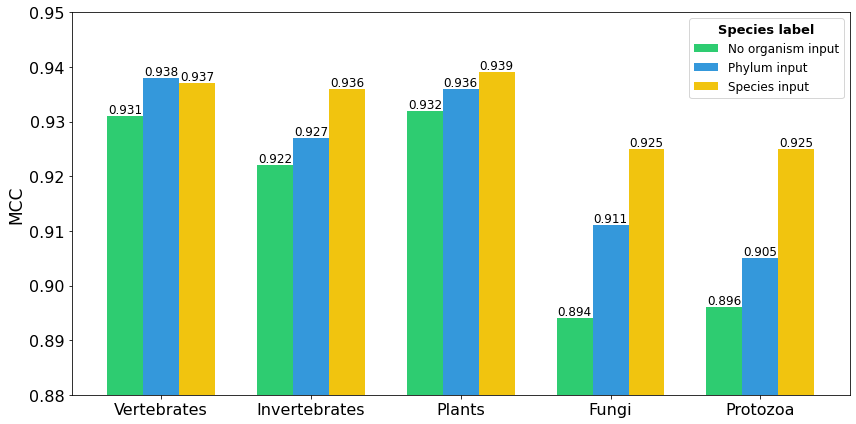

In [42]:
visualize_mcc(netstart_overall_df, 0.625,
              netstart_phylum_df, 0.625,
              netstart_species_unknown_df, 0.625,
              "")